In [85]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
import seaborn as sns
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### **Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. 

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

Carga desde archivo tipo excel (dar doble click para ver codigo) 
<!--
'''
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/06-05-Heart.csv?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
df = pd.read_csv(url, sep=',')
print(df.shape)
df.head()
''' -->

In [2]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [3]:
data.describe()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,220.000000,220.000000,220.000000,220.000000
mean,12.615537,9145.673391,1290.255505,5493.707773
std,2.817083,1291.485826,182.697673,384.789072
min,8.140713,6923.604000,857.491000,4596.805000
25%,10.394045,7970.166750,1152.180000,5307.975500
50%,11.986155,9115.132000,1268.917000,5527.687000
75%,14.096509,10423.498000,1401.581000,5748.512750
max,20.946380,11037.199000,1834.507000,6395.575000


In [4]:
data.columns

Index(['TD_13ciudades', 'Ocupados', 'Desocupados', 'Inactivos'], dtype='object')

In [5]:
#Matriz de resultados

Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
Resultados = pd.DataFrame(columns=Resultados_columnas)

Vamos a revisar diferentes modelos basados en los datos con transformaciones aplicadas (diferenciacion, logaritmica, desestacionalizar o combinaciones), despues de esto se realizará metodos de evaluacion (split) y se calculará el RSME para poder elegir el mejor, a estos se realizarpa la validacion de supuestos.

### Data raw 
(Sin transformaciones)

##### Metodo de Evaluación

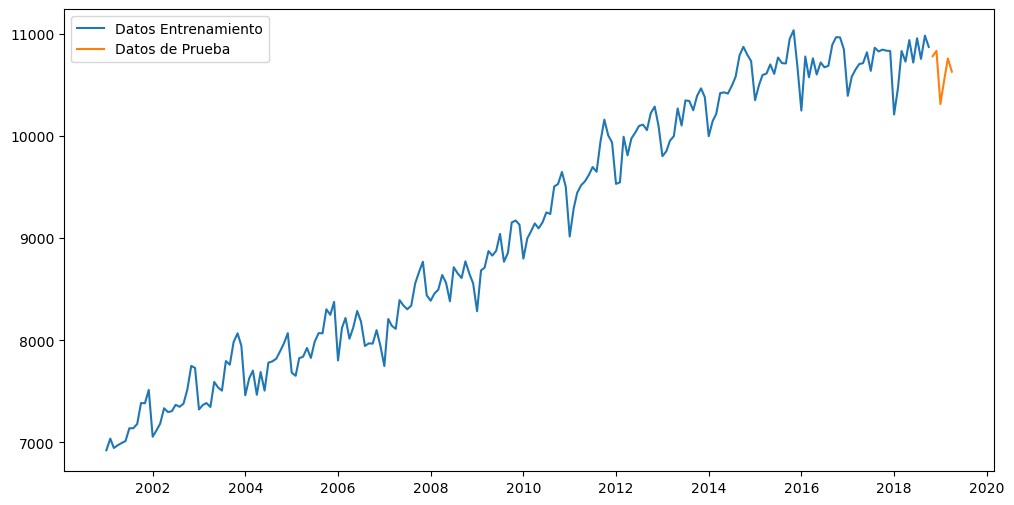

In [6]:
train_len = 214
train_raw = data[["Ocupados"]][:train_len]
test_raw = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_raw,label="Datos Entrenamiento")
plt.plot(test_raw,label="Datos de Prueba")
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


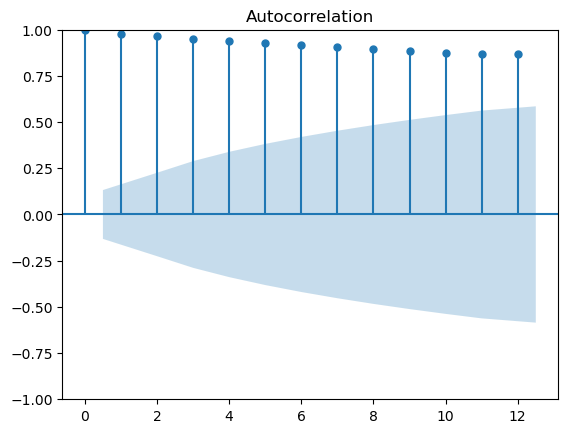

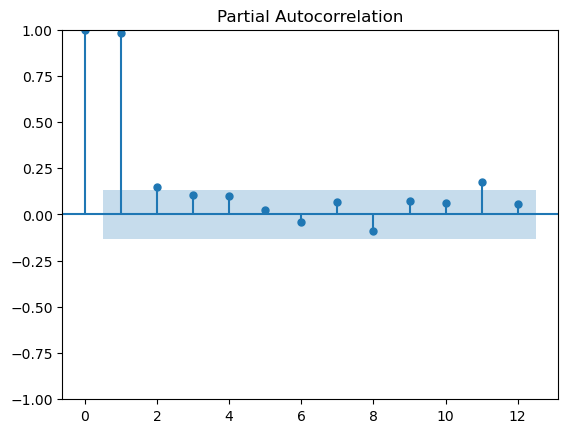

In [7]:
plot_acf(data['Ocupados'],lags=12);
plot_pacf(data['Ocupados'],lags=12);

## Auto Arima

In [8]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
modelo_raw = auto_arima(train_raw["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
print(modelo_raw.summary)
#fig = plt.figure(figsize=(12, 6))
#plt.plot(modelo_raw.resid(),label="Residuales")

<bound method ARIMA.summary of ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)>


In [9]:
pred_raw = modelo_raw.predict(n_periods=len(test_raw))
print(pred_raw)
# Calcula el RMSE
rmse_raw = np.sqrt(mean_squared_error(test_raw["Ocupados"], pred_raw))
# Calcula el coeficiente R2
r2_raw = r2_score(test_raw["Ocupados"], pred_raw)
print("Modelo-Sin transformaciones")
print(f'ORDEN: {modelo_raw.order}')
print(rmse_raw)
print(r2_raw)

2018-11-01    10918.120140
2018-12-01    10947.966695
2019-01-01    10971.604477
2019-02-01    10992.476040
2019-03-01    11012.115158
2019-04-01    11031.205182
Freq: MS, dtype: float64
Modelo-Sin transformaciones
ORDEN: (1, 1, 1)
381.6786569042785
-3.7050504200496555


In [10]:
# Agregamos al vector los resultados.
Resultados = Resultados.append({'Modelo': 'ARIMA sin transformaciones', 
                                'Configuración': f'{modelo_raw.order}', 
                                'RMSE': rmse_raw, 
                                'Coef R2': r2_raw}, ignore_index=True)
Resultados

C:\Users\CARLOS\AppData\Local\Temp\ipykernel_32944\1796175431.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'ARIMA sin transformaciones',


,Modelo,Configuración,RMSE,Coef R2
0,ARIMA sin transformaciones,"(1, 1, 1)",381.678657,-3.70505


### Data diferenciada
(Sin tendencia)

##### Transformacion

In [11]:
data_diff = data.diff() # se hace diferenciacion para eliminar la tendencia
valor_inicia = data[:1]
data_diff = data_diff[1:] #Quitamos el primer valor para poder 

##### Metodo de Evaluación

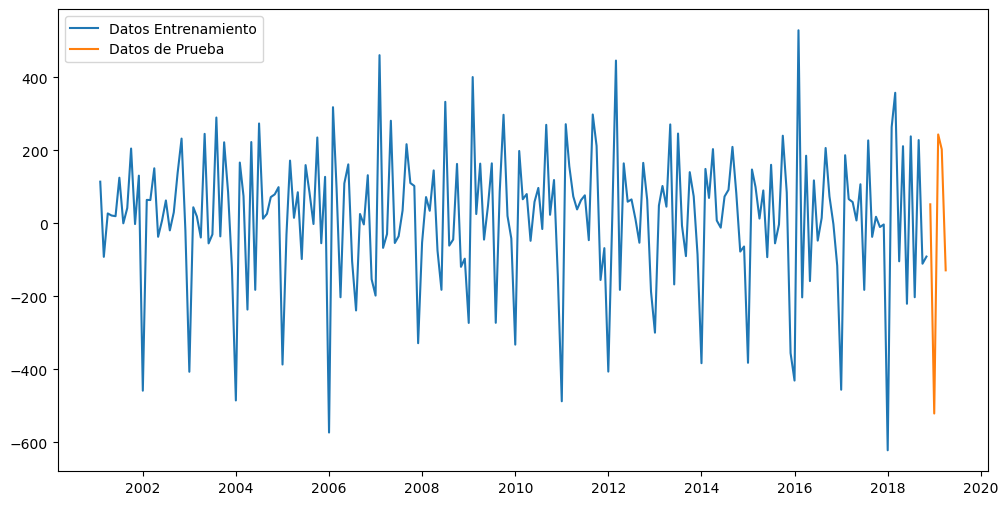

In [12]:
train_len = 214
train_diff = data_diff[["Ocupados"]][:train_len]
test_diff = data_diff[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_diff,label="Datos Entrenamiento")
plt.plot(test_diff,label="Datos de Prueba")
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


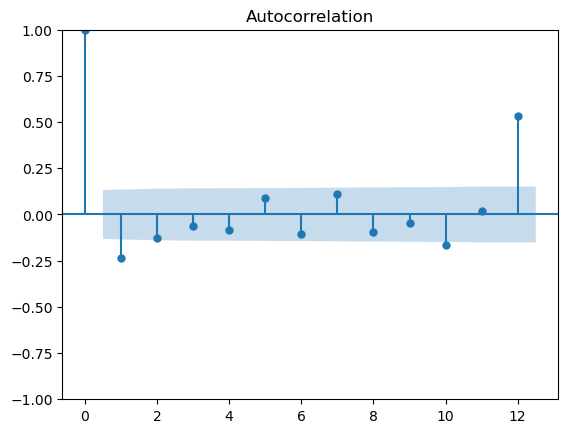

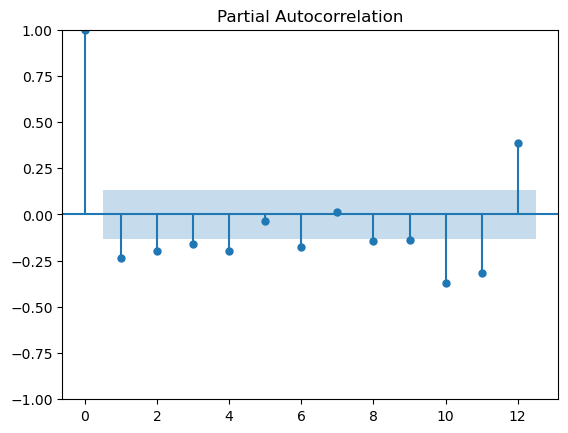

In [13]:
plot_acf(data_diff['Ocupados'],lags=12);
plot_pacf(data_diff['Ocupados'],lags=12);

<bound method ARIMA.summary of ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)>


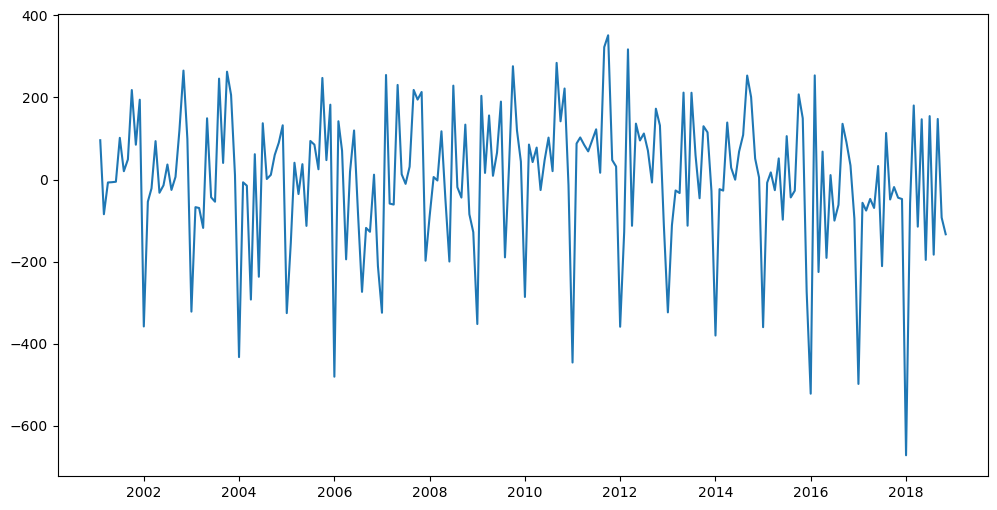

In [14]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
modelo_diff = auto_arima(train_diff["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
print(modelo_diff.summary)
fig = plt.figure(figsize=(12, 6))

plt.plot(modelo_diff.resid(),label="Residuales")


In [15]:
pred_diff = modelo_diff.predict(n_periods=len(test_diff))
# Calcula el RMSE
rmse_diff = np.sqrt(mean_squared_error(test_diff["Ocupados"], pred_diff))
# Calcula el coeficiente R2
r2_diff = r2_score(test_diff["Ocupados"], pred_diff)
print("Modelo-Dff)")
print(f'ORDEN: {modelo_diff.order}')
print(rmse_diff)
print(r2_diff)

Modelo-Dff)
ORDEN: (1, 0, 1)
291.3748869741292
-0.09817627750589186


In [16]:
# Agregamos al vector los resultados.
Resultados = Resultados.append({'Modelo': 'ARIMA Dff', 
                                'Configuración': f'{modelo_diff.order}', 
                                'RMSE': rmse_diff, 
                                'Coef R2': r2_diff}, ignore_index=True)
Resultados

C:\Users\CARLOS\AppData\Local\Temp\ipykernel_32944\3392121526.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'ARIMA Dff',


,Modelo,Configuración,RMSE,Coef R2
0,ARIMA sin transformaciones,"(1, 1, 1)",381.678657,-3.705050
1,ARIMA Dff,"(1, 0, 1)",291.374887,-0.098176


### Data diff+log
(Sin tendencia ni varianza)

##### Transformacion

In [17]:
data_log = np.log(data) # transformacion log sobre el total de los datos
data_log_diff = data_log.diff() #  transformacion diff sobre el total de los datos
valor_inicia =data_log['Ocupados'].iloc[213]
print(valor_inicia)
data_log_diff = data_log_diff[1:]

9.294160980540795


##### Metodo de Evaluación

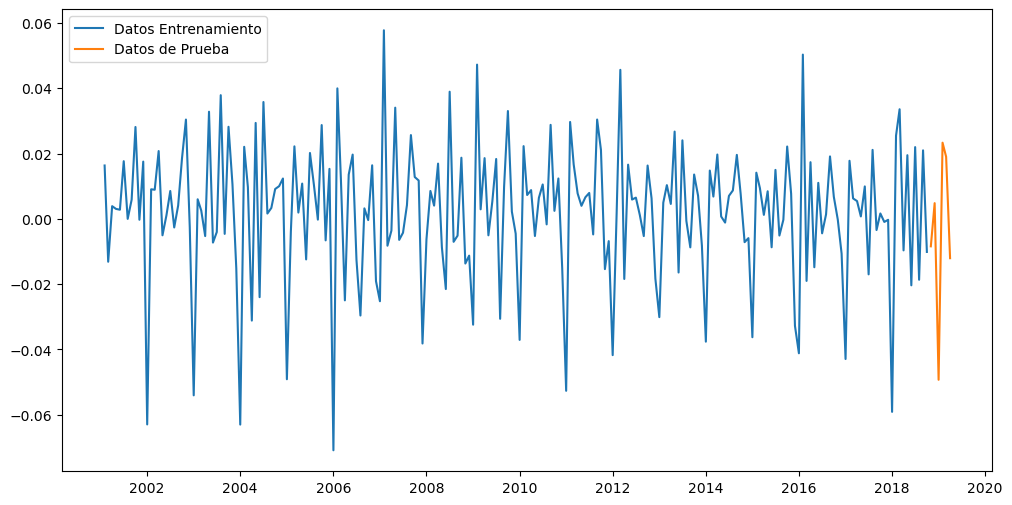

In [18]:
train_len = 213
train_log_diff = data_log_diff[["Ocupados"]][:train_len]
test_log_diff = data_log_diff[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_log_diff,label="Datos Entrenamiento")
plt.plot(test_log_diff,label="Datos de Prueba")
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


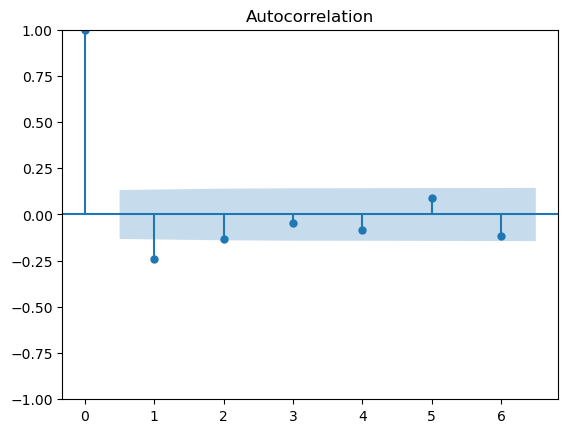

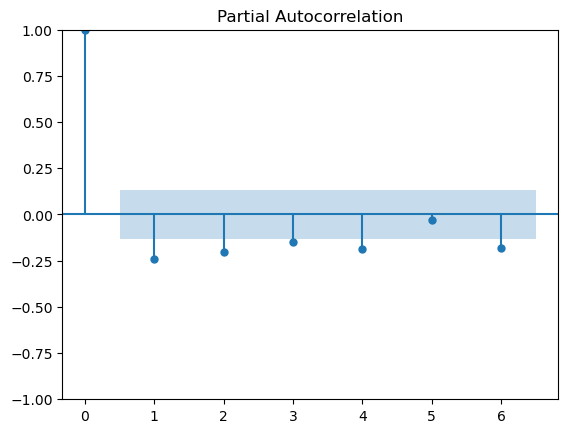

In [19]:
plot_acf(data_log_diff['Ocupados'],lags=6);
plot_pacf(data_log_diff['Ocupados'],lags=6);

In [20]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
modelo_log_diff = auto_arima(train_log_diff["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
print(modelo_log_diff.order)
#fig = plt.figure(figsize=(12, 6))
#plt.plot(modelo_log_diff.resid(),label="Residuales")

(1, 0, 2)


In [21]:
pred_log_diff = modelo_log_diff.predict(n_periods=len(test_log_diff)) # predicciones
print(pred_log_diff)

2018-11-01    0.005003
2018-12-01    0.003904
2019-01-01    0.002768
2019-02-01    0.002343
2019-03-01    0.002185
2019-04-01    0.002125
Freq: MS, dtype: float64


In [22]:
data_log['Ocupados'].iloc[213:][:1]

mes
2018-10-01    9.294161
Name: Ocupados, dtype: float64

In [23]:
hola = np.cumsum(np.concatenate((data_log['Ocupados'].iloc[213:][:1], pred_log_diff)))
hola

array([9.29416098, 9.29916431, 9.30306848, 9.305836  , 9.30817908,
       9.31036368, 9.3124891 ])

In [24]:
pred_log_diff = np.exp(hola)#np.power(10,hola)
pred_log_diff =pred_log_diff[1:]
pred_log_diff

array([10928.8822458 , 10971.63386069, 11002.04011195, 11027.84904131,
       11051.96678478, 11075.48180577])

In [25]:
# Calcula el RMSE
rmse_log_diff = np.sqrt(mean_squared_error(test_raw["Ocupados"] , pred_log_diff))
# Calcula el coeficiente R2
r2_log_diff = r2_score(test_raw["Ocupados"], pred_log_diff)
print("Modelo-  Log+Dff")
print(f'ORDEN: {modelo_log_diff.order}')
print(rmse_log_diff)
print(r2_log_diff)

Modelo-  Log+Dff
ORDEN: (1, 0, 2)
411.26447897562707
-4.462745062128081


In [26]:
# Agregamos al vector los resultados.
Resultados = Resultados.append({'Modelo': 'ARIMA Log+Dff', 
                                'Configuración': f'{modelo_log_diff.order}', 
                                'RMSE': rmse_log_diff, 
                                'Coef R2': r2_log_diff}, ignore_index=True)
Resultados

C:\Users\CARLOS\AppData\Local\Temp\ipykernel_32944\887390453.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'ARIMA Log+Dff',


,Modelo,Configuración,RMSE,Coef R2
0,ARIMA sin transformaciones,"(1, 1, 1)",381.678657,-3.705050
1,ARIMA Dff,"(1, 0, 1)",291.374887,-0.098176
2,ARIMA Log+Dff,"(1, 0, 2)",411.264479,-4.462745


In [27]:
# se puede ver una varianza notable en los resudios, aplicamos LOG para eliminar esta varianza
# pero debe ser antes de calcular diferenciacion puesto que nos genera valores negativos.

### Data Dff+ NSeason
(Ni varianza ni estacionalidad)

##### Transformacion

In [28]:
data_ds = sm.tsa.seasonal_decompose(data['Ocupados']) # 
datos_destacionalizados = data['Ocupados'] - data_ds.seasonal
data_Ds = datos_destacionalizados.diff() #  
data_Ds = data_Ds[1:] # Quitamos el primero de los datos

##### Metodo de Evaluación

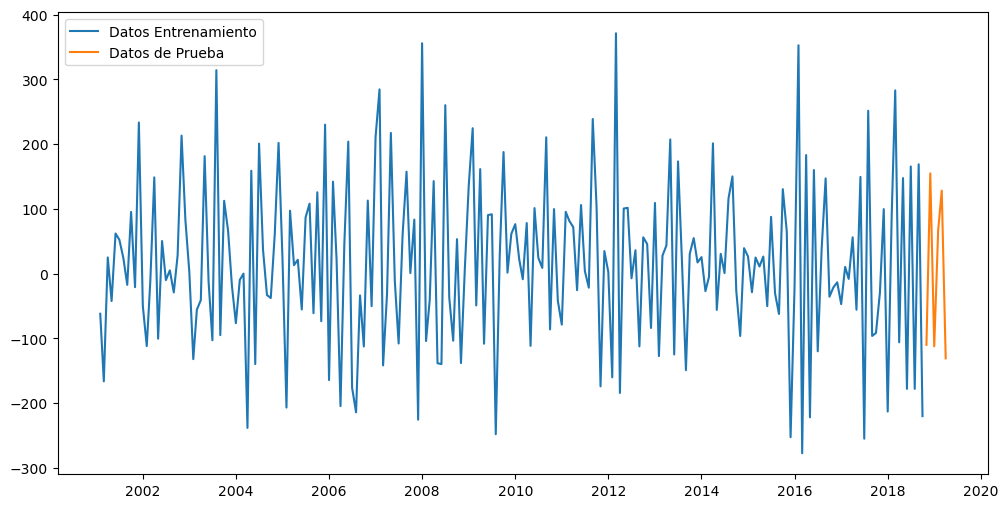

In [29]:
train_len = 213
train_Ds = data_Ds[:train_len]
test_Ds = data_Ds[train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ds,label="Datos Entrenamiento")
plt.plot(test_Ds,label="Datos de Prueba")
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


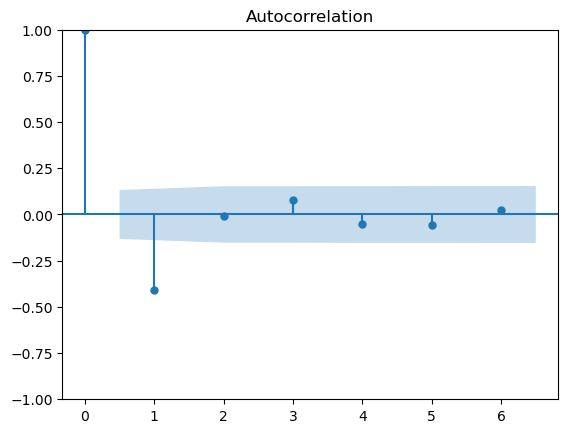

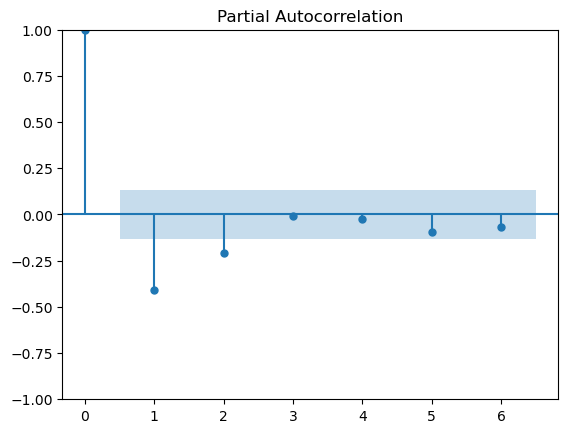

In [30]:
plot_acf(data_Ds,lags=6);
plot_pacf(data_Ds,lags=6);

In [31]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
modelo_Ds = auto_arima(train_Ds,max_p=10, max_q=10,information_criterion = ("aic"))
print(modelo_Ds.summary)
#fig = plt.figure(figsize=(12, 6))
#plt.plot(modelo_Ds.resid(),label="Residuales")

<bound method ARIMA.summary of ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)>


In [32]:
pred_Ds = modelo_Ds.predict(n_periods=len(test_Ds))

In [33]:
pred_Ds

2018-11-01    120.776275
2018-12-01     17.152554
2019-01-01     17.152554
2019-02-01     17.152554
2019-03-01     17.152554
2019-04-01     17.152554
Freq: MS, dtype: float64

In [34]:
hola = np.cumsum(np.concatenate((datos_destacionalizados.iloc[213:][:1], pred_Ds)))
print(hola)
hola =hola[1:]
hola

[10693.58029706 10814.356572   10831.50912566 10848.66167932
 10865.81423299 10882.96678665 10900.11934031]


array([10814.356572  , 10831.50912566, 10848.66167932, 10865.81423299,
       10882.96678665, 10900.11934031])

In [35]:
# Calcula el RMSE
rmse_Ds = np.sqrt(mean_squared_error(datos_destacionalizados[214:], hola))
# Calcula el coeficiente R2
r2_Ds = r2_score(datos_destacionalizados[214:], hola)
print("Modelo- (Ni varianza ni estacionalidad))")
print(f'ORDEN: {modelo_Ds.order}')
print(rmse_Ds)
print(r2_Ds)


Modelo- (Ni varianza ni estacionalidad))
ORDEN: (0, 0, 1)
177.61460775836588
-4.4085322130242


In [36]:
# Agregamos al vector los resultados.
Resultados = Resultados.append({'Modelo': 'ARIMA Dff+ NSeason', 
                                'Configuración': f'{modelo_Ds.order}', 
                                'RMSE': rmse_Ds, 
                                'Coef R2': r2_Ds}, ignore_index=True)
Resultados

C:\Users\CARLOS\AppData\Local\Temp\ipykernel_32944\3343512168.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'ARIMA Dff+ NSeason',


,Modelo,Configuración,RMSE,Coef R2
0,ARIMA sin transformaciones,"(1, 1, 1)",381.678657,-3.705050
1,ARIMA Dff,"(1, 0, 1)",291.374887,-0.098176
2,ARIMA Log+Dff,"(1, 0, 2)",411.264479,-4.462745
3,ARIMA Dff+ NSeason,"(0, 0, 1)",177.614608,-4.408532


In [ ]:
sdsdsd

### Data Log+Dff+ NSeason
(Sin Varianza, Sin Tendencia, Sin Estacionalidad)

##### Transformacion

In [57]:
data_ds = sm.tsa.seasonal_decompose(data['Ocupados']) # 
datos_destacionalizados = data['Ocupados'] - data_ds.seasonal # Quitamos estacionalidad
data_Ds_l = np.log(datos_destacionalizados) # Quitamos Varianza
data_Dsl = data_Ds_l.diff() #Quitamos tendecnia
data_Dsl = data_Dsl[1:] # Quitamos el primero de los datos

##### Metodo de Evaluación

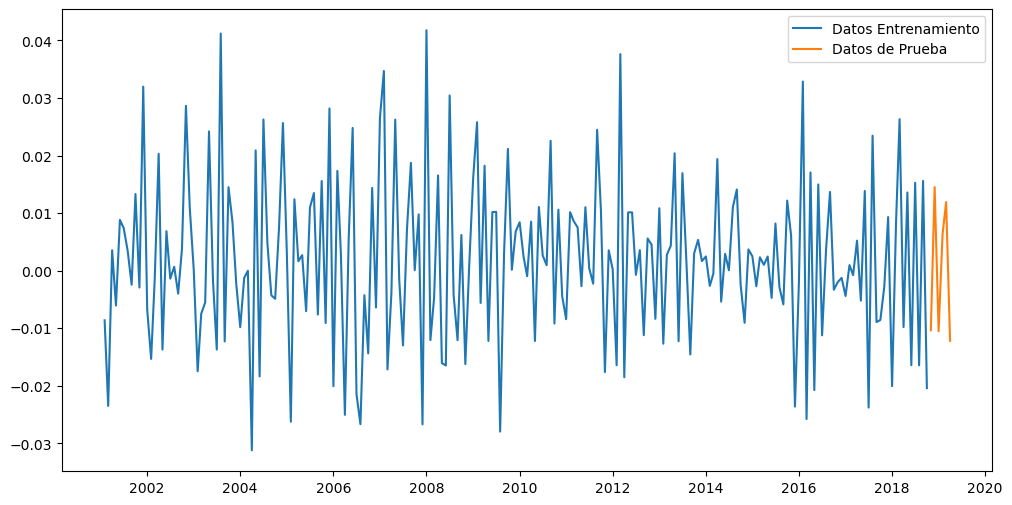

In [58]:
train_len = 213
train_Dsl = data_Dsl[:train_len]
test_Dsl = data_Dsl[train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_Dsl,label="Datos Entrenamiento")
plt.plot(test_Dsl,label="Datos de Prueba")
plt.legend()
plt.show()

C:\Users\CARLOS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


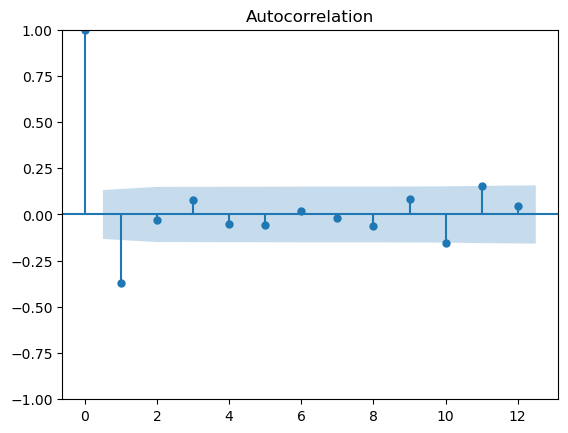

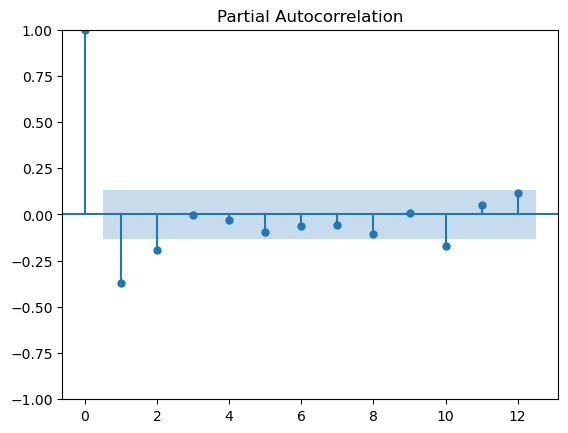

In [59]:
plot_acf(data_Dsl,lags=12);
plot_pacf(data_Dsl,lags=12);

In [60]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
modelo_Dsl = auto_arima(train_Dsl,max_p=10, max_q=10,information_criterion = ("aic"))
print(modelo_Dsl.summary)
#fig = plt.figure(figsize=(12, 6))
#plt.plot(modelo_Ds.resid(),label="Residuales")

<bound method ARIMA.summary of ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)>


In [66]:
pred_Dsl = modelo_Dsl.predict(n_periods=len(test_Ds))
#pred_Dsl_ = pred_Dsl + data_ds.seasonal[214:] 

In [67]:
hola = np.cumsum(np.concatenate((data_Ds_l.iloc[213:][:1], pred_Dsl)))
hola

array([9.27739887, 9.2883379 , 9.29026192, 9.29218594, 9.29410997,
       9.29603399, 9.29795802])

In [69]:
pred_ = np.exp(hola)#np.power(10,hola)
pred_ = pred_[1:]
pred_ = pred_ + data_ds.seasonal[214:] 
pred_

mes
2018-11-01    11011.025712
2018-12-01    10929.161201
2019-01-01    10541.427102
2019-02-01    10738.566928
2019-03-01    10834.254197
2019-04-01    10857.436025
Name: seasonal, dtype: float64

In [72]:
# Calcula el RMSE
rmse_ = np.sqrt(mean_squared_error(test_raw["Ocupados"] , pred_))
# Calcula el coeficiente R2
r2_ = r2_score(test_raw["Ocupados"], pred_log_diff)
print("Modelo- Log+Dff+ NSeason")
print(f'ORDEN: {modelo_log_diff.order}')
print(rmse_log_diff)
print(r2_log_diff)

Modelo- Log+Dff+ NSeason
ORDEN: (1, 0, 2)
183.0379128710409
-4.462745062128081


In [73]:
# Agregamos al vector los resultados.
Resultados = Resultados.append({'Modelo': 'ARIMA  Log+Dff+ NSeason', 
                                'Configuración': f'{modelo_Dsl.order}', 
                                'RMSE': rmse_, 
                                'Coef R2': r2_}, ignore_index=True)
Resultados

C:\Users\CARLOS\AppData\Local\Temp\ipykernel_32944\139939630.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'ARIMA  Log+Dff+ NSeason',


,Modelo,Configuración,RMSE,Coef R2
0,ARIMA sin transformaciones,"(1, 1, 1)",381.678657,-3.705050
1,ARIMA Dff,"(1, 0, 1)",291.374887,-0.098176
2,ARIMA Log+Dff,"(1, 0, 2)",411.264479,-4.462745
3,ARIMA Dff+ NSeason,"(0, 0, 1)",177.614608,-4.408532
4,ARIMA Log+Dff+ NSeason,"(0, 0, 1)",183.037913,-4.462745


In [75]:
residuos = modelo_Dsl.resid()

# Para que los suspuestos se cumplan NO TENGO QUE RECHAZAR H0

## Probemos el modelo ARIMA  [Pruebas] 
#### Log+Dff+NSeason

## Autocorrelacion

In [77]:
signo = residuos>0
runstest_1samp(signo, correction=False) #estadistico y probabilidad que hay por encima del estadistico

(0.7830142386276566, 0.4336187507209627)

El segundo valor corresponde al p-valor=0.43, por lo tanto considerando un 
=0.05, los resultados obtenidos no permiten rechazar la hipótesis nula, es decir, la serie y1 parece comportarse como un ruido blanco, **No presenta autocorrelación**.

In [78]:
# prueba de Box-Pierce y la modificación de Ljung-Box 
sm.stats.acorr_ljungbox(residuos, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.028411,0.866146,0.028015,0.867074


Los resultados **no permiten rechazar h0** (valor p de BoxPierce 0.877) la **no autocorrelacion** y
por tanto se puede concluir que **no existe autocorrelacion en la serie**. Es decir, con
esta prueba y en este aspecto, la serie parece **comportarse como un ruido blanco**. (media cero, varianza cero y autocorrelacion no cambia en el tiempo)


In [80]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuos, lags=range(1,11), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,0.028411,0.866146,0.028015,0.867074,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,0.028483,0.985859,0.028085,0.986056,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,0.259761,0.967410,0.253984,0.968437,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,1.056634,0.901090,1.028620,0.905426,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,4.213516,0.519102,4.082719,0.537569,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,4.706986,0.581905,4.557827,0.601638,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,5.804071,0.562804,5.608988,0.586073,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,6.882000,0.549416,6.636781,0.576279,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,6.966782,0.640578,6.717225,0.666533,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,9.116080,0.521124,8.746562,0.556313,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


## Homoscedasticidad y Heteroscedasticidad

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [82]:
sm.stats.acorr_ljungbox((residuos-residuos.mean())**2, lags=range(1,11), return_df=True,boxpierce=True )
### SE RESTA LA MEDIA Y SE ELEVA AL CUADRADO 

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.197147,0.657034,0.194396,0.659283
2,1.478304,0.477519,1.451718,0.483909
3,1.495648,0.683275,1.468658,0.689523
4,3.205051,0.524116,3.130357,0.536252
5,4.278455,0.510060,4.168813,0.525376
6,8.390347,0.210877,8.127705,0.228896
7,8.882248,0.261221,8.599014,0.282741
8,17.098909,0.029095,16.433505,0.036579
9,17.275450,0.044573,16.601014,0.055343
10,18.534577,0.046588,17.789864,0.058613


Si p-value es Menor a 0.05 (Significancia) entonces Rechazo y concluyo que los errores NO son homocedasticos -

por tanto, en este caso son Homocedasticos

### **Normalidad**

$H{0}:$ Los datos siguen una distribucion normal

$H{1}:$ Los datos No siguen una distribucion normal

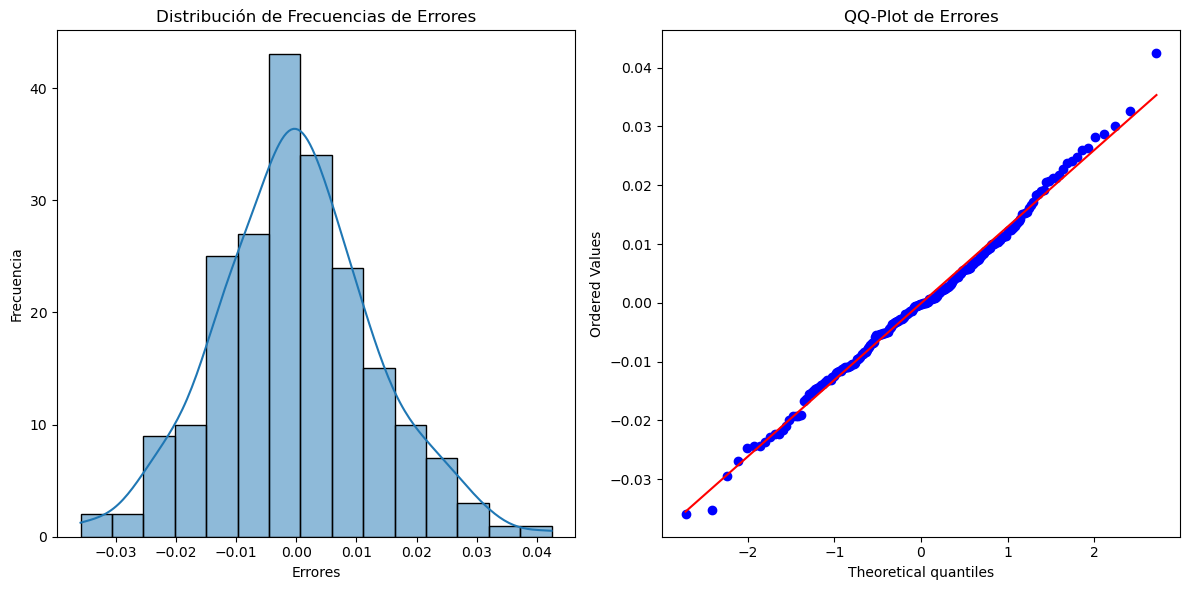

In [86]:
# Distribución de Frecuencias
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuos, kde=True)
plt.xlabel('Errores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencias de Errores')

# QQ-Plot
plt.subplot(1, 2, 2)
stats.probplot(residuos, plot=plt) #sm.qqplot(residuos_pg5,line="s")
plt.title('QQ-Plot de Errores')

plt.tight_layout()
plt.show()

In [90]:
print('ShapiroWilks:\r\n',stats.shapiro(residuos),'\r\nJarqueBera:\r\n',stats.jarque_bera(residuos))

ShapiroWilks:
 ShapiroResult(statistic=0.9947823286056519, pvalue=0.6741769909858704) 
JarqueBera:
 SignificanceResult(statistic=1.7354154518829568, pvalue=0.41991300255199304)


Para ambas pruebas el p-value > 0.05 , por tanto no hay suficiente informacion estadistica para rechazar la hipótesis de que los datos provienen de una distribución normal, es decir, los datos provienen de una distribucion normal.

In [91]:
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,ARIMA sin transformaciones,"(1, 1, 1)",381.678657,-3.705050
1,ARIMA Dff,"(1, 0, 1)",291.374887,-0.098176
2,ARIMA Log+Dff,"(1, 0, 2)",411.264479,-4.462745
3,ARIMA Dff+ NSeason,"(0, 0, 1)",177.614608,-4.408532
4,ARIMA Log+Dff+ NSeason,"(0, 0, 1)",183.037913,-4.462745


## CONCLUSION

Con estas pruebas de supuestos, y que es el modelo con menor Error RMSE : 177.61460

El mejor modelo es ARIMA (0,0,1) -> con transformaciones Logaritmica, diferenciada y sin estacionalidad.

In [173]:
Resultados_t1 = pd.read_csv('resultados_t1_modelo.csv')
Resultados_t2 = pd.read_csv('resultados_t2_modelo.csv')
Resultados_t3 = Resultados

Resultados_t1['Origen'] = 'Taller 1'
Resultados_t2['Origen'] = 'Taller 2'
Resultados_t3['Origen'] = 'Taller 3'

In [178]:
Resultados_combinados = pd.concat([Resultados_t1, Resultados_t2,Resultados_t3], ignore_index=True)

In [182]:
Resultados_combinados = Resultados_combinados.sort_values(by='RMSE', ascending=True)
top_15_resultados = Resultados_combinados.head(15)
top_15_resultados

,Modelo,Configuración,RMSE,Coef R2,Origen
33,Suavizacion Exp Lineal de Winters (Holt-Winters),add/None/add,74.994180,0.818355,Taller 1
45,Tendencia Pol. grado 5 + Estacionalidad,x**5 + estacionalidad,91.055527,0.732218,Taller 2
36,Suavizacion Exp Lineal de Winters (Holt-Winters),add/None/mul,93.497528,0.717662,Taller 1
41,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/None/mul,97.452411,0.693272,Taller 1
38,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/None/add,115.889161,0.566235,Taller 1
44,Tendencia Cubica + Estacionalidad,x**3 + estacionalidad,130.743940,0.447908,Taller 2
27,Suavizacion Exp Lineal de Winters (Holt-Winters),add/mul/mul,154.837076,0.225684,Taller 1
25,Suavizacion Exp Lineal de Winters (Holt-Winters),add/add/mul,156.414737,0.209824,Taller 1
28,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/mul/mul,160.577047,0.167210,Taller 1
30,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/add/mul,162.249785,0.149769,Taller 1


Comparando con los demas tallers, podemos decir que ARMIA (0,0,1) con diferenciacion y sin estacionalidad, cumple, pero el modelo de suavizacion lineal de winters (holt-winters) se ajusta mejor a estos datos.

## PRONOSTICO

In [152]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.tail()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575


In [ ]:
## Transformaciones 
data_ds = sm.tsa.seasonal_decompose(data['Ocupados']) # 
datos_destacionalizados = data['Ocupados'] - data_ds.seasonal # Quitamos estacionalidad
data_Dsl = datos_destacionalizados.diff() #Quitamos tendecnia
data_Dsl = data_Dsl[1:] # Quitamos el primero de los datos

In [193]:
h= 6
res = results.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0) 

fore = results.predict(h,return_conf_int=False)
fore_real = np.cumsum(np.concatenate((datos_destacionalizados.iloc[219:][:1], fore)))[1:] # invirtiendo dff
fore_real_ = fore_real + data_ds.seasonal[-6] # invirtiendo desestacionalidad

preds = pd.DataFrame(np.column_stack([fore_real_,fore_real_+np.cumsum(q1) , fore_real_+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=6,freq='MS')
preds = preds.set_index(range_dates)
preds 

,Point_forecast,lower_95,upper_95
2019-05-01,10953.514688,10738.951072,11198.050805
2019-06-01,10969.903841,10528.518463,11457.659984
2019-07-01,10986.292994,10323.928309,11718.585255
2019-08-01,11002.682147,10119.487960,11979.575433
2019-09-01,11019.071300,9915.047612,12239.184612
2019-10-01,11035.460453,9715.061766,12498.793791


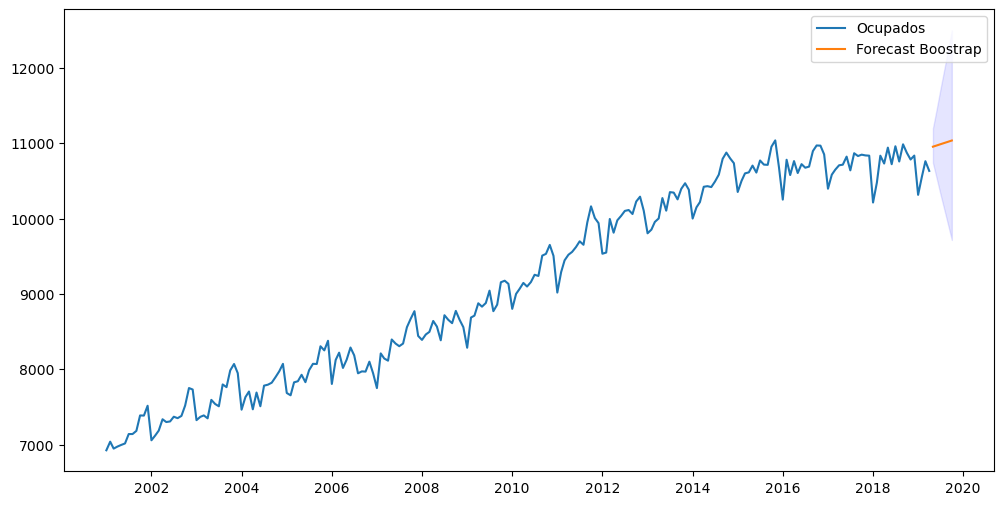

In [195]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data["Ocupados"],label="Ocupados")
plt.plot(preds.index,preds['Point_forecast'],label="Forecast Boostrap")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [169]:
preds

,Point_forecast,lower_95,upper_95
2019-05-01,10937.728077,10716.898576,11178.946250
2019-06-01,10954.117230,10506.465967,11438.555429
2019-07-01,10970.506384,10306.480121,11696.111425
2019-08-01,10986.895537,10106.494274,11957.101604
2019-09-01,11003.284690,9902.053926,12216.710783
2019-10-01,11019.673843,9703.879464,12476.319962
